In [9]:
import numpy as np
import pyvista as pv
from icosphere import icosphere
from scipy.sparse import csc_array, csc_matrix, identity
from scipy.sparse.linalg import spsolve 
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import pymeshfix as mf

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

1
Smallest Edge Length: 1.0514622242382672 L^2 norm of error: 1.935075922291505e-06
2
Smallest Edge Length: 0.348615488820338 L^2 norm of error: 3.8038732997362915e-07
3
Smallest Edge Length: 0.162567228883416 L^2 norm of error: 1.623292502336326e-07
4
Smallest Edge Length: 0.07795674630655638 L^2 norm of error: 7.638155378182003e-08
5
Smallest Edge Length: 0.03812562092627532 L^2 norm of error: 3.802544311431109e-08
6
Smallest Edge Length: 0.01884848359270766 L^2 norm of error: 2.057058042643223e-08


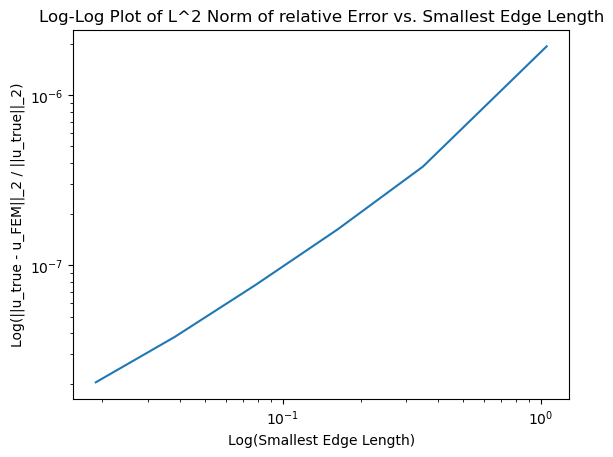

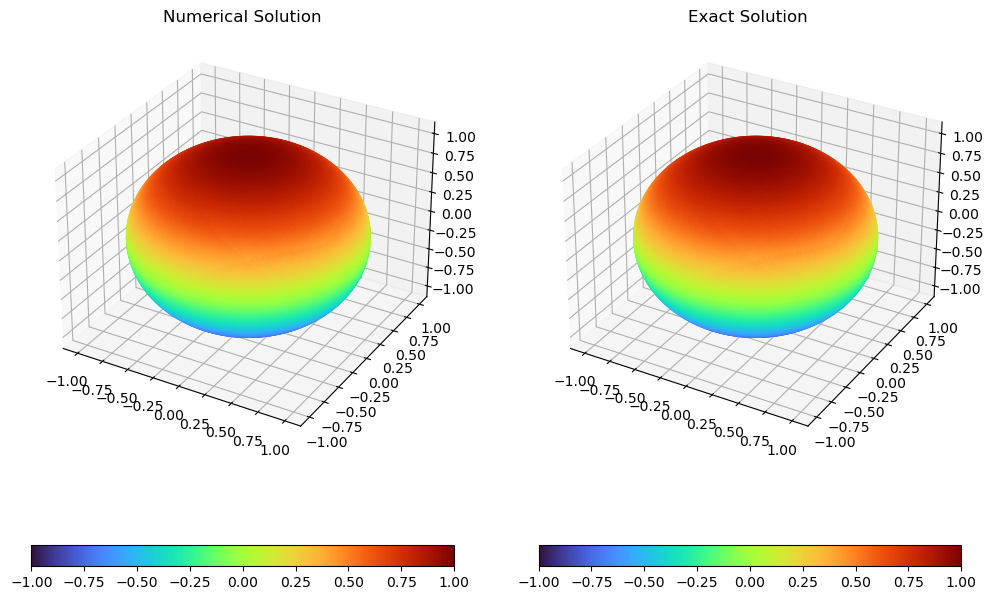

In [12]:
def plot_solutions(vertices, fem, exact, X, Y, Z):

    fig = plt.figure(figsize=(12, 8))

    combined_min = min(np.min(fem), np.min(exact))
    combined_max = max(np.max(fem), np.max(exact))
    common_norm = Normalize(vmin=combined_min, vmax=combined_max)

    # Plot numerical solution
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    scatter1 = ax1.scatter(X, Y, Z, c=fem, cmap='turbo', norm=common_norm)
    fig.colorbar(ScalarMappable(norm=common_norm, cmap='turbo'), ax=ax1, orientation='horizontal')
    ax1.set_title(f"Numerical Solution")

    # Plot exact solution
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    scatter2 = ax2.scatter(X, Y, Z, c=exact, cmap='turbo', norm=common_norm)
    fig.colorbar(ScalarMappable(norm=common_norm, cmap='turbo'), ax=ax2, orientation='horizontal')
    ax2.set_title(f"Exact Solution ")

    plt.savefig(f"numerical_exact_solution.png")
    plt.show()

def cartestian2Spherical(xyz):
    """
    Function to convert from cartesian to spherical coordinates

    Parameters:
        xyz: N x 3 array of cartesian (x,y,z) coordinates

    Return:
        rthph: N x 3 array of spherical (r,theta,phi). r is the radial coordinate,
               theta is the azimuthal coordinate in range [-pi,pi] and phi is the 
               elevation coordinate in range [0,pi]
    """
    rthph = np.zeros(xyz.shape)
    r = np.sqrt(xyz[:,0]**2 + xyz[:,1]**2 + xyz[:,2]**2)
    rthph[:,0] = r#Radius
    rthph[:,1] = np.arctan2(xyz[:,1], xyz[:,0])#Azimuth angle 
    rthph[:,2] = np.arccos(xyz[:,2]/r)#Elevation angle defined downward from +z-axis
    return rthph

def generateLocalSMN(vert_arr, tri_arr, k, omega):
    """
    Function to generate the "local" stiffness(S) mass (M) and N 
    matrices for a given FEM triangle. Let N_v be the number of verticies
    and N_t be the number of triangles

    Parameters:
        vert_arr: N_v x 3 array of (x,y,z) coordinates of verticies
        tri_arr: N_t x 3 array of of FEM Triangles. These are in
                 vertex (integer) coordinates
        k: Index in tri_arr of local S,M matrices being generated
        omega: Angular frequency of Helmholtz equation

    Return:
        k_arr: Array of length 3 of indices of vertex of this FEM triangle
        Sk: Local stiffness matrix corresponding to triangle k
        Mk: Local mass matrix corresonding to triangle k
        Nk: Local N matrix corresponding to triangle k
    """
    #Get indices in vert_arr from tri_arr
    k_arr = tri_arr[k,:]
    #Get (x,y,z)-coordinates of verticies
    r1 = vert_arr[k_arr[0],:]
    r2 = vert_arr[k_arr[1],:]
    r3 = vert_arr[k_arr[2],:]
    #Get edges
    E1 = r2 - r3
    E2 = r3 - r1
    E3 = r1 - r2
    A = 0.5*np.linalg.norm(np.cross(E1,E2))
    Sk = np.zeros((3,3), dtype=np.double)
    Mk = np.zeros((3,3), dtype=np.double)
    if A > 0:
        Sk = (1.0/(4.0*A))*np.array([[np.dot(E1,E1),np.dot(E1,E2), np.dot(E1,E3)],
                                     [np.dot(E2,E1),np.dot(E2,E2), np.dot(E2,E3)],
                                     [np.dot(E3,E1),np.dot(E3,E2), np.dot(E3,E3)]], dtype=np.double)
        Mk = (A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]], dtype=np.double)
        Nk = (omega**2)*(A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]], dtype=np.double)
    return k_arr, (-1.0*Sk), Mk, Nk

"""
def generateSM(vert_arr, tri_arr):
    Function to generate the stiffness(S) and mass (M) matrices
    In a finite element solver

    Parameters:
        vert_arr: N_v x 3 array of (x,y,z) coordinates of verticies. N_v is the
                  number of verticies
        tri_arr: N_t x 3 array of integer "vertex" coordinates corresponding
                 to the 3 verticies of each FEM triangle. N_t is the number of 
                 triangles

    Return:
        S: N_v x N_v Stiffness matrix  
        M: N_v x N_v Mass matrix sparse 
    N_v = vert_arr.shape[0]
    S = np.zeros((N_v,N_v), dtype=np.double)
    M = np.zeros((N_v,N_v), dtype=np.double)
    for k in np.arange(tri_arr.shape[0]):
        #V_S = V_M = I = J = [] 
        k_arr, Sk, Mk = generateLocalSM(vert_arr, tri_arr, k)
        for i in np.arange(3):
            for j in np.arange(3):
                S[k_arr[i]][k_arr[j]] += Sk[i][j]
                M[k_arr[i]][k_arr[j]] += Mk[i][j]
    return S,M
    """

def generateSMSparse(vert_arr, tri_arr, omega):
    """
    Function to generate the stiffness(S) and mass (M) matrices for use
    In a finite element solver. This function returns S,M as sparse 
    Matrices

    Parameters:
        vert_arr: N_v x 3 array of (x,y,z) coordinates of verticies. N_v is the
                  number of verticies
        tri_arr: N_t x 3 array of integer "vertex" coordinates corresponding
                 to the 3 verticies of each FEM triangle. N_t is the number of 
                 triangles
        omega: Angular frequency of Helmholtz equation

    Return:
        S: N_v x N_v Stiffness matrix stored as sparse csc_matrix 
        M: N_v x N_v Mass matrix sparse stired as sparse csc_matrix
    """
    N_v = vert_arr.shape[0]
    V_S = []
    V_M = []
    I = []
    J = []
    for k in np.arange(tri_arr.shape[0]): 
        k_arr, Sk, Mk, Nk = generateLocalSMN(vert_arr, tri_arr, k, omega)
        for i in np.arange(3):
            for j in np.arange(3):
                V_S.append(Sk[i][j] + Nk[i][j])
                I.append(int(k_arr[i]))
                J.append(int(k_arr[j]))
                V_M.append(Mk[i][j])

    S = csc_matrix((np.array(V_S, dtype=np.double), (np.array(I, dtype=int),np.array(J, dtype=int))), shape=(N_v, N_v), dtype=np.double)
    M = csc_matrix((np.array(V_M, dtype=np.double), (np.array(I, dtype=int),np.array(J, dtype=int))), shape=(N_v, N_v), dtype=np.double)
    return S,M

def main():
    #Manfactured solution
    h = []
    L2 = []
    L2_rel = []
    idx = 0
    prev_p_dist = 1e15
    omega = 200.0*np.pi
    while len(h) < 6:
        N = idx
        V,T = icosphere(N)#Generate array of verticies/triangles using icosphere package
        N_v = V.shape[0]
        p_dist = np.min(pdist(V))
        appended = False
        if (p_dist <= 0.5*prev_p_dist) and (len(h) < 6):
            h.append(p_dist)
            print(len(h))
            prev_p_dist = p_dist
            appended = True
        elif len(h) >= 6:
            h.append(p_dist)
            print(len(h))
            prev_p_dist = p_dist
            appended = True
        S,M = generateSMSparse(V,T, omega)#Generate sparse FEM stiffness and mass matrices
        #plt.spy(S)
        #plt.show()
        rthph = cartestian2Spherical(V)#Convert vertex (x,y,z) cartesian coordinates to spherica (r,theta,phi)
        u_true = np.cos(rthph[:,2])
        f = ((omega**2) - 2.0)*np.cos(rthph[:,2])
        epsilon = 1.0e-8
        A = S + (epsilon*identity(N_v, dtype=np.double, format="csc"))
        b = M.dot(f)
        u_FEM = spsolve(A,b)
        u = u_true - u_FEM
        if appended:
            L2.append(np.sqrt(np.dot(u, M.dot(u))))#Calculate L^2 norm of error
            L2_rel.append(L2[-1]/np.sqrt(np.dot(u_true, M.dot(u_true))))
            print("Smallest Edge Length: " + str(h[-1]) + " L^2 norm of error: " + str(L2_rel[-1]))
        idx += 1

    plt.loglog(h, L2_rel)
    plt.xlabel("Log(Smallest Edge Length)")
    plt.ylabel("Log(||u_true - u_FEM||_2 / ||u_true||_2)")
    plt.title("Log-Log Plot of L^2 Norm of relative Error vs. Smallest Edge Length")
    plt.show()

    plot_solutions(vertices=V, fem=u_FEM, exact=u_true, X=V[:,0], Y=V[:,1], Z=V[:,2])


if __name__ == "__main__":
    main()